In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
!pwd::

/usr/bin/sh: 1: pwd::: not found


In [2]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np


from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [3]:
!nvidia-smi

Sat Mar 16 19:40:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           Off | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8              N/A / ERR! |      1MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup
Here we define some output paths.

In [4]:
extract_features.confs
match_features.confs

{'superpoint+lightglue': {'output': 'matches-superpoint-lightglue',
  'model': {'name': 'lightglue', 'features': 'superpoint'}},
 'disk+lightglue': {'output': 'matches-disk-lightglue',
  'model': {'name': 'lightglue', 'features': 'disk'}},
 'superglue': {'output': 'matches-superglue',
  'model': {'name': 'superglue',
   'weights': 'outdoor',
   'sinkhorn_iterations': 50}},
 'superglue-fast': {'output': 'matches-superglue-it5',
  'model': {'name': 'superglue',
   'weights': 'outdoor',
   'sinkhorn_iterations': 5}},
 'NN-superpoint': {'output': 'matches-NN-mutual-dist.7',
  'model': {'name': 'nearest_neighbor',
   'do_mutual_check': True,
   'distance_threshold': 0.7}},
 'NN-ratio': {'output': 'matches-NN-mutual-ratio.8',
  'model': {'name': 'nearest_neighbor',
   'do_mutual_check': True,
   'ratio_threshold': 0.8}},
 'NN-mutual': {'output': 'matches-NN-mutual',
  'model': {'name': 'nearest_neighbor', 'do_mutual_check': True}},
 'adalam': {'output': 'matches-adalam', 'model': {'name': 'a

In [5]:

#
feature_configs = [
    ("superpoint_max", "superpoint+lightglue"),
    ("r2d2", "superglue"),
    ("d2net-ss", "superglue"),
    ("sift", "superglue"),
    ("sosnet", "superglue"),
    ("disk", "disk+lightglue"),
    ("dir", "superglue"),
    ("netvlad", "superglue"),
    ("openibl", "superglue"),
    ("eigenplaces", "superglue")
]

In [6]:
images = Path("../data/images")
outputs = Path("../data/hloc/demo/")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

fconf = feature_configs[5]
feature_conf = extract_features.confs[fconf[0]]
matcher_conf = match_features.confs[fconf[1]]

In [7]:
# feature_conf["model"]["nms_radius"] = 28
#feature_conf["preprocessing"]["resize_max"] = 256
feature_conf

{'output': 'feats-disk',
 'model': {'name': 'disk', 'max_keypoints': 5000},
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}

In [8]:
# matcher_conf["model"]["distance_threshold"] = 100.5
# matcher_conf["model"]["do_mutual_check"] = False
matcher_conf

{'output': 'matches-disk-lightglue',
 'model': {'name': 'lightglue', 'features': 'disk'}}

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

3 mapping images


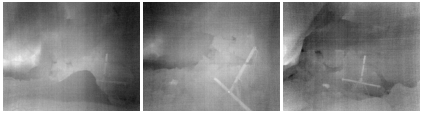

In [9]:
references = [p.relative_to(images).as_posix() for p in (images).iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [10]:
extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/03/16 19:40:23 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/3 [00:00<?, ?it/s]

[2024/03/16 19:40:25 hloc INFO] Finished exporting features.
[2024/03/16 19:40:25 hloc INFO] Found 3 pairs.
[2024/03/16 19:40:25 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/3 [00:00<?, ?it/s]

[2024/03/16 19:40:51 hloc INFO] Finished exporting matches.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [11]:
f = extract_features.h5py.File("../data/hloc/demo/features.h5")
keypoints = np.array(f["image_00.png"]["keypoints"])
f.close()
keypoints.shape

(5000, 2)

In [12]:
f = match_features.h5py.File("../data/hloc/demo/matches.h5")
kp_matches = np.where(np.array(f['image_01.png']['image_00.png']['matches0']) != -1) 
f.close()
kp_matches[0].shape #TODO supposedly not real matches

(7,)

In [13]:
!cat ../data/hloc/demo/pairs-sfm.txt

image_01.png image_00.png
image_01.png image_02.png
image_00.png image_02.png

In [14]:
#model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
# fig = viz_3d.init_figure()
# viz_3d.plot_reconstruction(fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True)
# fig.show()

## triangulate 3d pointsriangulate(correspondences, projection_matrices)

In [15]:
import h5py
import numpy as np
from src.pycv.perspective import triangulate
from hloc.utils.io import get_matches, get_keypoints

def read_projection_matrices(calib_path):
    # Discover projection matrix files
    projection_files = [p for p in calib_path.iterdir() if p.suffix == '.csv' and p.stem.startswith('P_')]

    # Sort projection files based on the index in the filename
    projection_files.sort(key=lambda p: int(p.stem.split('_')[1]))

    # Read projection matrices
    projection_matrices = {}
    for file_path in projection_files:
        camera_index = int(file_path.stem.split('_')[1])
        matrix = np.loadtxt(file_path)
        projection_matrices[file_path.name] = matrix

    return list(projection_matrices.values())

def load_pairs_sfm(file_path):
    pairs = []
    with open(file_path, 'r') as f:
        for line in f:
            pair = line.strip().split()
            pairs.append(pair)
    return pairs

def load_features(file_path, image_name):
    with h5py.File(file_path, 'r') as f:
        keypoints = np.array(f[image_name]["keypoints"])
    return keypoints

def load_matches(file_path, image_name1, image_name2):
    m, s = get_matches(file_path, image_name1, image_name2)
    #print(s)
    return m


# Load pairs from pairs-sfm.txt
pairs = load_pairs_sfm("../data/hloc/demo/pairs-sfm.txt")
#print(pairs)

# Load projection matrices into a dictionary
projection_matrices = read_projection_matrices(Path("../data/calib"))
#print(projection_matrices)
# Triangulate 3D points for each pair
points3D = []
for pair in pairs:
    image_name1, image_name2 = pair
    to_idx = lambda x: int(Path(x).stem.split('_')[1])
    idx_1 = to_idx(image_name1)
    idx_2 = to_idx(image_name2)
    print(f"evaluating {pair} (index {idx_1} and {idx_2})")
    # Load features for the pair
    keypoints1 = load_features("../data/hloc/demo/features.h5", image_name1)
    keypoints2 = load_features("../data/hloc/demo/features.h5", image_name2)
    # Load matches for the pair
    kp_matches = load_matches("../data/hloc/demo/matches.h5", image_name1, image_name2)
    #kp_matches_2 = load_matches("../data/hloc/demo/matches.h5", image_name2, image_name1)
    # Extract correspondences
    #print(kp_matches, keypoints1.shape, keypoints2.shape)
    correspondences = np.array([keypoints1[kp_matches[:,0]], keypoints2[kp_matches[:,1]]])
    # Triangulate 3D points
    print(correspondences.shape)
    _pts3d = triangulate(correspondences, [projection_matrices[idx_1], projection_matrices[idx_2]])
    points3D.append(_pts3d)
points3D = np.vstack(points3D)
print(f"{len(points3D)}")

evaluating ['image_01.png', 'image_00.png'] (index 1 and 0)
(2, 7, 2)
evaluating ['image_01.png', 'image_02.png'] (index 1 and 2)
(2, 19, 2)
evaluating ['image_00.png', 'image_02.png'] (index 0 and 2)
(2, 21, 2)
47


In [16]:
from src.pycv.io import write_ply
write_ply("../data/hloc/demo/points3D.ply", points3D)

In [17]:
# import plotly.express as px
# import pandas as pd
# df = pd.DataFrame(points3D, columns = ["x", "y", "z"])
# fig = px.scatter_3d(df, x='x', y='y', z='z')
# fig.update_traces(marker={'size': 1})
# fig.show()

In [18]:
from hloc.utils.viz_3d import init_figure, plot_points, plot_camera
from src.pycv.perspective import decompose_perspective_projection_matrix

KRTs = [decompose_perspective_projection_matrix(p) for p in projection_matrices]

fig = init_figure()
for cam in KRTs:
    plot_camera(fig, cam[1],cam[2],cam[0],size=2.0, fill=False, text="cam") # somehow not showing

plot_points(fig, pts=points3D, color="grey")
fig.show()

## ICP Alignment

In [19]:
from src.pycv.io import load_ply
lidar_roi = load_ply("../data/ushichka/lidar_roi.ply")
lidar_roi.shape

  0%|          | 0/5376775 [00:00<?, ?it/s]

(5376775, 3)

In [20]:
import open3d as o3d

source_cloud = o3d.geometry.PointCloud()
target_cloud = o3d.geometry.PointCloud()
source_cloud.points = o3d.utility.Vector3dVector(points3D)
target_cloud.points = o3d.utility.Vector3dVector(lidar_roi[::100,:])

icp_threshold = 100000 # search radius for correspondences
icp_max_iteration = 1000000000

# Perform ICP registration
reg_p2p = o3d.pipelines.registration.registration_icp(
    source_cloud, target_cloud, icp_threshold, np.identity(4),
    o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=False),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=icp_max_iteration)
)

# Get the transformation matrix
transformation_matrix = reg_p2p.transformation

# Apply the transformation to the source point cloud
# NOTE: this does not do anything for some reason
#source_cloud_transformed = source_cloud.transform(transformation_matrix) 
def transform_points(pts, transform):
    transformed = transform @ np.pad(pts, ((0,0),(0,1)), constant_values=1).T
    return transformed.T[:,:3]

source_cloud_transformed = o3d.geometry.PointCloud()
source_cloud_transformed.points = o3d.utility.Vector3dVector(transform_points(np.asarray(source_cloud.points), transformation_matrix))


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [21]:
reg_p2p.inlier_rmse

1.3366198787067176

In [22]:
#np.asarray(source_cloud.points) - source_cloud_transformed
transformation_matrix

array([[ 0.95543396,  0.03100409, -0.2935723 , -2.53940899],
       [ 0.25665827,  0.40409175,  0.87797288, -2.97521324],
       [ 0.14585089, -0.91419287,  0.37812553, -1.53016952],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [23]:
from scipy.spatial.transform import Rotation
Rotation.from_matrix(transformation_matrix[:3,:3].copy()).as_euler('xyz', degrees=True)

array([-67.5291908 ,  -8.38655571,  15.03639074])

In [24]:
transformation_matrix[:3,3]

array([-2.53940899, -2.97521324, -1.53016952])

In [32]:
np.savetxt("../data/hloc/demo/transformation.csv", transformation_matrix)

In [25]:
fig = init_figure()
plot_points(fig, pts=np.asarray(target_cloud.points)[::1,:], color="grey")
plot_points(fig, pts=np.asarray(source_cloud.points), color="blue")
plot_points(fig, pts=np.asarray(source_cloud_transformed.points), color="green")
fig.show()

In [33]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import scipy.linalg as la

def get_transformed_positions(Ps, trans):
    positions = []
    for P in Ps:
        P_est = P @ la.inv(trans)
        pose_est = la.null_space(P_est) / la.null_space(P_est)[-1]
        position_est = pose_est[:3].flatten()
        positions.append(position_est)
    return np.array(positions)

def get_original_positions(Ps):
    positions = []
    for P in Ps:
        P_est = P
        pose_est = la.null_space(P_est) / la.null_space(P_est)[-1]
        position_est = pose_est[:3].flatten()
        positions.append(position_est)
    return np.array(positions)


fig = go.Figure()

_point_cloud1 = np.asarray(target_cloud.points)[::10,:]
_point_cloud2 = np.asarray(source_cloud.points)
_point_cloud3 = np.asarray(source_cloud_transformed.points)
_point_cloud4 = np.asarray(get_transformed_positions(projection_matrices, transformation_matrix))
_point_cloud5 = np.asarray(get_original_positions(projection_matrices))
fig.add_trace(go.Scatter3d(x=_point_cloud1[:, 0], y=_point_cloud1[:, 1], z=_point_cloud1[:, 2],
                            mode='markers', marker=dict(size=1,color='grey', opacity=0.5),
                            name='Reference'))

fig.add_trace(go.Scatter3d(x=_point_cloud2[:, 0], y=_point_cloud2[:, 1], z=_point_cloud2[:, 2],
                            mode='markers', marker=dict(size=1,color='blue', opacity=0.5),
                            name='Triangulated'))

fig.add_trace(go.Scatter3d(x=_point_cloud3[:, 0], y=_point_cloud3[:, 1], z=_point_cloud3[:, 2],
                            mode='markers', marker=dict(size=3,color='green', opacity=0.5),
                            name='Transformed'))

fig.add_trace(go.Scatter3d(x=_point_cloud4[:, 0], y=_point_cloud4[:, 1], z=_point_cloud4[:, 2],
                            mode='markers', marker=dict(size=5,color='black', opacity=1),
                            name='Estimated Positions'))

fig.add_trace(go.Scatter3d(x=_point_cloud5[:, 0], y=_point_cloud5[:, 1], z=_point_cloud5[:, 2],
                            mode='markers', marker=dict(size=5,color='white', opacity=1),
                            name='Estimated Positions'))

fig.update_layout(scene=dict(xaxis=dict(title='X'),
                             yaxis=dict(title='Y'),
                             zaxis=dict(title='Z')),
                  title='Point Clouds Comparison')



fig.show()

In [27]:
## Estimate perspective projection

In [28]:

# def merge_correspondences(*args):
#     camera_idx = set()
#     for _, idxs in args:
#         camera_idx.update(idxs)

#     cps = []
#     for cps_list, idxs in args:
#         for i in range(cps_list.shape[1]):
#             cp = []
#             for idx in sorted(camera_idx):
#                 if idx == idxs[0]:
#                     cp.append(cps_list[0, i,:])
#                 elif idx == idxs[1]:
#                     cp.append(cps_list[1, i,:])
#                 else:
#                     cp.append([None,None])

#             cps.append(cp)

#     cps = np.array(cps)
#     cps = np.swapaxes(cps,0,1)
#     return cps
        

# csps_list = []

# # Load pairs from pairs-sfm.txt
# pairs = load_pairs_sfm("../data/hloc/demo/pairs-sfm.txt")
# for pair in pairs:
#     image_name1, image_name2 = pair
#     to_idx = lambda x: int(Path(x).stem.split('_')[1])
#     idx_1 = to_idx(image_name1)
#     idx_2 = to_idx(image_name2)
#     print(f"collecting {pair} (index {idx_1} and {idx_2})")
#     # Load features for the pair
#     keypoints1 = load_features("../data/hloc/demo/features.h5", image_name1)
#     keypoints2 = load_features("../data/hloc/demo/features.h5", image_name2)
#     # Load matches for the pair
#     kp_matches = load_matches("../data/hloc/demo/matches.h5", image_name1, image_name2)
#     #kp_matches_2 = load_matches("../data/hloc/demo/matches.h5", image_name2, image_name1)
#     # Extract correspondences
#     #print(kp_matches, keypoints1.shape, keypoints2.shape)
#     correspondences = np.array([keypoints1[kp_matches[:,0]], keypoints2[kp_matches[:,1]]])

#     csps_list.append((correspondences, (idx_1, idx_2)))


# combined = merge_correspondences(*csps_list)
# #pd.DataFrame(combined[:,:,0].T)

In [29]:
#  combined.shape, combined

In [30]:
# from src.pycv.perspective import bundle_adjustment
# bundle_adjustment(combined)

We also visualize which keypoints were triangulated into the 3D model.

In [31]:
visualization.visualize_sfm_2d(model, images, color_by="visibility", n=3)

NameError: name 'model' is not defined

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=5)

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by="depth", n=5)

# read constructed 3D points

In [ ]:
import pycolmap

# Colmap dense reconstruction (only with cuda)

In [ ]:
import pycolmap

In [ ]:
image_dir = images
output_path = outputs
mvs_path = output_path / "mvs"

In [ ]:
# dense reconstruction
#pycolmap.undistort_images(mvs_path, output_path, image_dir)

In [ ]:
#pycolmap.patch_match_stereo(mvs_path)  # requires compilation with CUDA


In [ ]:
#pycolmap.stereo_fusion(mvs_path / "dense.ply", mvs_path)

# loc

In [ ]:
query = "image_00.png"

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r) for r in references]
ref_ids = [r.image_id for r in ref_ids if r is not None]
conf = {
    "estimation": {"ransac": {"max_error": 250}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)